In [97]:
from pyspark import SparkContext, SparkConf
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType
import matplotlib.pyplot as plt
from os.path import abspath
import pyspark.sql.functions as f
from pyspark.sql import SparkSession
from pyspark.sql import Row
import os
import findspark
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


findspark.init()

In [98]:
os.environ["JAVA_HOME"] = r"/usr/lib/jvm/java-1.11.0-openjdk-amd64"
os.environ["SPARK_HOME"] = r"/home/guilherme/als_recomendacao_spark_app/spark/spark"
os.environ["LIVY_CONF_DIR"] = r"/home/guilherme/als_recomendacao_spark_app/livy_server"

In [99]:

warehouse_location = abspath('spark-warehouse')



In [100]:

conf = SparkConf()
conf.set("spark.master","local[*]")
conf.set("spark.executor.memory", "4g")
conf.set("spark.driver.memory", "4g")
conf.set("spark.sql.adaptive.enabled","true")
conf.set("spark.sql.adaptive.localShuffleReader.enabled","true")
conf.set("spark.dynamicAllocation.enabled", "false")
conf.set("spark.sql.adaptive.optimizeSkewsInRebalancePartitions.enabled","true")
conf.set("spark.sql.adaptive.skewJoin.enabled","true")
conf.set("spark.sql.statistics.size.autoUpdate.enabled","true")
conf.set("spark.sql.inMemoryColumnarStorage.compressed","true")
conf.set("hive.exec.dynamic.partition", "true")
conf.set("hive.exec.dynamic.partition.mode", "nonstrict")
conf.set("spark.sql.ansi.enabled","true")
conf.set('spark.driver.extraClassPath', r"/home/guilherme/als_recomendacao_spark_app/sqlserverjars/mssql-jdbc-12.2.0.jre11.jar")
conf.set('spark.executor.extraClassPath', r"/home/guilherme/als_recomendacao_spark_app/sqlserverjars/mssql-jdbc-12.2.0.jre11.jar")
spark = SparkSession.builder\
        .config(conf=conf)\
        .config("spark.sql.warehouse.dir", warehouse_location)\
        .config("spark.sql.catalogImplementation", "hive") \
        .enableHiveSupport() \
        .getOrCreate()
    

23/07/10 00:49:42 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [101]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

/home/guilherme/als_recomendacao_spark_app/venv/lib/python3.11/site-packages/pyspark/sql/context.py:112: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [102]:
df_business = spark.read.option("inferSchema",True) \
                 .options(header='True', inferSchema='True', delimiter=';') \
                .csv(r"/home/guilherme/als_recomendacao_spark_app/app/csvteste/tabela_teste.csv")

In [103]:
df_discador = spark.read.option("inferSchema",True) \
                 .options(header='True', inferSchema='True', delimiter=';') \
                .csv(r"/home/guilherme/als_recomendacao_spark_app/app/csvteste/tab_tipo_atendimento.csv").withColumnRenamed("ID AGENTE", "ID_AGENTE")

In [104]:
df_business = df_business.select("ID_AGENTE", "HORA", 
                                 "CAMPANHA_ID",  
                                 "ESTADO", "PLANO"
                                 ,"TIPO_PLANO"
                                 ,"OPERADORA","FORMA_PAGTO"
                                 ,"VENDA","ID_AUDITOR","ID_VENDA","CAMPANHA"
        ,"ID_TICKET")


df_business = df_business.filter((df_business['VENDA'] == 'Sim'))

In [105]:
#df_discador = df_discador.join(df_business, on='ID_AGENTE', how='left')


In [106]:
'''
df_discador.columns

df_discador.select(['ID_AGENTE', 'TIPO DE CHAMADA'
                  ,'CLASSIFICACAO','INICIO','FIM','TEMPO TOTAL',
                  'SESSIONID','ID EXTERNO','CAMPANHA_ID','ESTADO','PLANO'
                  ,'ID_VENDA','ID_TICKET','ID_AUDITOR',
                  'VENDA','FORMA_PAGTO','OPERADORA','TIPO_PLANO'
                  ]).show(2)
'''


"\ndf_discador.columns\n\ndf_discador.select(['ID_AGENTE', 'TIPO DE CHAMADA'\n                  ,'CLASSIFICACAO','INICIO','FIM','TEMPO TOTAL',\n                  'SESSIONID','ID EXTERNO','CAMPANHA_ID','ESTADO','PLANO'\n                  ,'ID_VENDA','ID_TICKET','ID_AUDITOR',\n                  'VENDA','FORMA_PAGTO','OPERADORA','TIPO_PLANO'\n                  ]).show(2)\n"

In [107]:
#https://plotly.com/python/histograms/
#histograma

In [108]:
df = px.data.tips()

business = df_business.select('ID_AGENTE').collect()
review_list = [business[i][0] for i in range(len(business))]


fig.update_layout(bargap=0.2)
fig.show()

In [109]:
lista_campanha = df_business.select('CAMPANHA').collect()
campanhas = [lista_campanha[i][0] for i in range(len(lista_campanha))]

In [110]:

text = " ".join(review for review in campanhas)


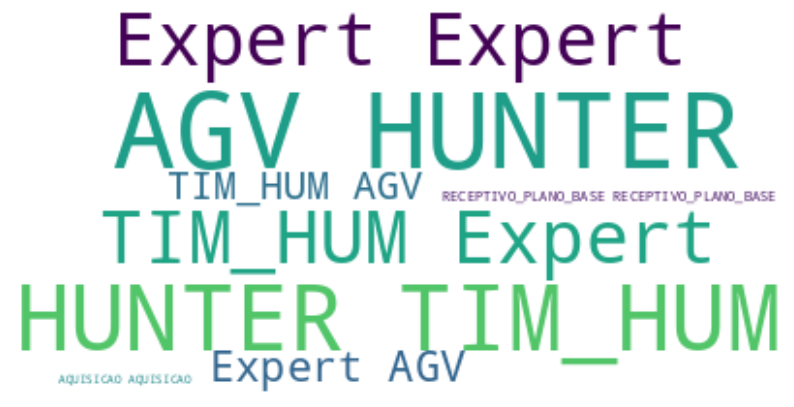

In [111]:
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [112]:
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['ID_VENDA', 'ID_AGENTE']]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(df_business).transform(df_business)
transformed.select(['ID_AGENTE', 'ID_VENDA','ID_AGENTE_index', 'ID_VENDA_index'])

DataFrame[ID_AGENTE: int, ID_VENDA: int, ID_AGENTE_index: double, ID_VENDA_index: double]

In [113]:
(training, test) = transformed.randomSplit([0.8, 0.2])


In [ ]:
als=ALS(maxIter=5,
        regParam=0.09,
        rank=25,
        userCol="ID_VENDA_index",
        itemCol="ID_AGENTE_index",
        ratingCol="CAMPANHA",
        coldStartStrategy="drop",
        nonnegative=True)

model=als.fit(training)

In [ ]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="CAMPANHA",predictionCol="prediction")
predictions=model.transform(test)
rmse=evaluator.evaluate(predictions)
print("RMSE="+str(rmse))